<a href="https://colab.research.google.com/github/lasiadhi/Prediction-of-hypoxemia-trend/blob/master/RF_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#################################################
###### @author: Lasith Adhikari (python 3)  #####
############ Created on Dec 1, 2019 ############
# Code description: 
# Train ML models to predict hypoxemia transition with labs, vitals, demo, fluids
# Added baseline PF (PF1 as a feature)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import os

random.seed(9001)
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
#from pygam import LogisticGAM
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
import time 
from sklearn.metrics import precision_recall_curve
#from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
from sklearn.utils import resample   # for upsample the minor class

In [0]:
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

In [0]:
# RF model: 
def fitRandomForestClassifier(X_train, X_test, y_train, y_test):
    
    print ('Parameter tunning and feature selection for RandomForestClassifier: ')
    
    kbest = SelectKBest(f_classif)  # ANOVA F-value between label/feature for classification tasks (F-test captures only linear dependency)
    
    # Create a RF classifier:
    #-1 sets #jobs to the #cores
    #The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
    
    clf = RandomForestClassifier(random_state=0, class_weight='balanced',n_jobs=-1)   
    
    pipeline = Pipeline([('kbest', kbest), ('rf', clf)])
    

    # first run:
    n_est               = [1000, 1500, 2000] # default=10
    min_sample_leaf     = [2, 6, 11, 15, 20, 30, 35]  # default=2
    kbest_vals          = [40, 60, 70,'all']
    max_features        = ['auto', 3, 7, 10, 12, 15]  # (0, n_features <= kbest_vals)

    ''' 
    # second run:
    n_est               = [1500] # default=10
    min_sample_leaf     = [2]  # default=2
    kbest_vals          = [70, 'all']
    max_features        = [8,12,15]
    '''  
    
    param_grid = { 
    'rf__n_estimators': n_est,              # must have two underscores to split rf and the parameter variable
    'rf__min_samples_leaf': min_sample_leaf,
    'kbest__k' : kbest_vals,
    'rf__max_features': max_features
    }
    
    
    CV_rfc = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv= 5,verbose=2,n_jobs=-1)
    CV_rfc.fit(X_train, y_train)
    print (CV_rfc.best_params_)   # print the best parameters
    
    # perform preditction using the best RF model
    predicted_y = CV_rfc.predict(X_test)
    probs       = CV_rfc.predict_proba(X_test)

    # generate some evaluation metrics
    print ('Accuracy of the RF model with selected features: ', metrics.accuracy_score(y_test, predicted_y))
    print ('ROC-AUC of the RF model with selected features: ',  metrics.roc_auc_score(y_test, probs[:,1]))   
    
    finalFeatureIndices = CV_rfc.best_estimator_.named_steps['kbest'].get_support(indices=True)
    X_important_train = X_train.iloc[:, finalFeatureIndices]
    X_important_test = X_test.iloc[:, finalFeatureIndices]
    
    
    print ("Selected features for the model: ", list(X_important_train.columns))
    return probs[:,1],X_important_train,X_important_test, CV_rfc

In [0]:
def plot_metrics(y_test,pred_probs_RF):
    
    # generate a df with 'tn','fp','fn','tp' for all thresholds
    df_values = pd.DataFrame(columns=['tn','fp','fn','tp'])
    thresholds = np.arange(min(pred_probs_RF),max(pred_probs_RF),0.005)
    for cut in thresholds:
        y_score_ = (pred_probs_RF>cut)*1
        row = pd.Series(list(metrics.confusion_matrix(y_test, y_score_).ravel()),index=['tn','fp','fn','tp'], name=cut)
        df_values = df_values.append(row)
    #compute specificty
    spec = df_values['tn']/(df_values['tn']+df_values['fp']+1e-100) # added 1e-100 to avoid div by zero by any case
    #compute sensitivity (recall)
    sen = df_values['tp']/(df_values['tp']+df_values['fn']+1e-100)
    #compute precesion
    pres = df_values['tp']/(df_values['tp']+df_values['fp']+1e-100)
    
    plt.gcf().set_size_inches(15, 8)
    plt.plot(thresholds, pres, 'b', label='Precision (PPV)')
    plt.plot(thresholds, sen, 'g', label = 'Recall (Sensitivity)')
    plt.plot(thresholds, spec, 'r', label = 'Specificity')
    plt.xlabel('Threshold', fontsize=15)
    plt.legend(loc='lower center', fontsize=15)
    plt.ylim([0,1])
    #plt.axvline(x=optimal_threshold, color='black',linestyle='dashed')
    plt.show()

In [0]:
# Define data file path to be read
FILENAME_X_test = '../Data/data_with_baseline_PF/X_test.csv' 
FILENAME_X_train = '../Data/data_with_baseline_PF/X_train.csv' 
FILENAME_y_test = '../Data/data_with_baseline_PF/y_test.csv' 
FILENAME_y_train = '../Data/data_with_baseline_PF/y_train.csv' 

X_train = pd.read_csv(FILENAME_X_train, index_col=0)
X_test = pd.read_csv(FILENAME_X_test, index_col=0)
y_train = pd.read_csv(FILENAME_y_train, index_col=0)
y_test = pd.read_csv(FILENAME_y_test, index_col=0)

In [0]:
'''
###################### OPTIONAL: Solution for imbalance dataset: Upsample minority class ########### 
X_y_train = X_train.join(y_train)
X_y_tr_majo = X_y_train[X_y_train.is_worse == 0]
X_y_tr_mino = X_y_train[X_y_train.is_worse == 1]
  
# upsample minority class
X_y_mino_upsampled = resample(X_y_tr_mino, replace=True, n_samples=X_y_tr_majo.shape[0], random_state=0) 
X_y_upsampled = pd.concat([X_y_tr_majo, X_y_mino_upsampled]) # now we have 50% data from each class
y_train = X_y_upsampled.is_worse.to_frame()
X_train = X_y_upsampled.drop('is_worse', axis=1)

In [0]:
# Imputation X_train:
medians_from_train = X_train.median().round(2)
X_train[medians_from_train.index] = X_train[medians_from_train.index].fillna(medians_from_train)

In [0]:
# Use imputed meadian values from X-train to impute X-test
X_test[medians_from_train.index] = X_test[medians_from_train.index].fillna(medians_from_train)

In [0]:
X_train.shape

(6767, 80)

In [0]:
X_test.shape

(2901, 80)

In [0]:
# code categrorical columns:
X_train['gender'] = X_train['gender'].astype('category').cat.codes
X_test['gender'] = X_test['gender'].astype('category').cat.codes

X_train['ethnicity'] = X_train['ethnicity'].astype('category').cat.codes
X_test['ethnicity'] = X_test['ethnicity'].astype('category').cat.codes

X_train['unittype'] = X_train['unittype'].astype('category').cat.codes
X_test['unittype'] = X_test['unittype'].astype('category').cat.codes

X_train['unitstaytype'] = X_train['unitstaytype'].astype('category').cat.codes
X_test['unitstaytype'] = X_test['unitstaytype'].astype('category').cat.codes

X_train['BMI_category'] = X_train['BMI_category'].astype('category').cat.codes
X_test['BMI_category'] = X_test['BMI_category'].astype('category').cat.codes

X_train['is_low_urine'] = X_train['is_low_urine'].astype('category').cat.codes
X_test['is_low_urine'] = X_test['is_low_urine'].astype('category').cat.codes

X_train['vasopressor'] = X_train['vasopressor'].astype('category').cat.codes
X_test['vasopressor'] = X_test['vasopressor'].astype('category').cat.codes

X_train['min_t_gcs'] = X_train['min_t_gcs'].astype('category').cat.codes
X_test['min_t_gcs'] = X_test['min_t_gcs'].astype('category').cat.codes

X_train['max_t_gcs'] = X_train['max_t_gcs'].astype('category').cat.codes
X_test['max_t_gcs'] = X_test['max_t_gcs'].astype('category').cat.codes

In [0]:
# test for any null values:
print('Null in X_train: ', X_train.isnull().sum(axis=0).sum())
print('Null in X_test: ', X_test.isnull().sum(axis=0).sum())

# check dump model accuracy (if we predict every test case as 1)
dump_accuracy = (y_test.sum()/len(y_test))*100
print ('Dump model accuracy (if we predict all test cases as 1):' + str(dump_accuracy))

Null in X_train:  0
Null in X_test:  0
Dump model accuracy (if we predict all test cases as 1):is_worse    22.268183
dtype: float64


In [0]:
## Random Forest Classifier model with CV
pred_probs_RF, iXtrain, iXtest, CV_rfc = fitRandomForestClassifier(X_train, X_test, y_train.is_worse, y_test.is_worse)

Parameter tunning and feature selection for RandomForestClassifier: 
Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed: 59.0min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed: 84.7min
/local/home/Lasith/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed: 110.2min finished


{'kbest__k': 40, 'rf__max_features': 15, 'rf__min_samples_leaf': 35, 'rf__n_estimators': 1500}
Accuracy of the RF model with selected features:  0.687693898655636
ROC-AUC of the RF model with selected features:  0.8030287012692813
Selected features for the model:  ['gender', 'age', 'unitstaytype', 'min_t_spo2', 'min_t_nibp_diastolic', 'min_t_nibp_mean', 'max_t_respiratoryrate', 'max_t_spo2', 'max_t_temperature', 'avg_t_respiratoryrate', 'avg_t_spo2', 'avg_t_temperature', 'min_t_BUN', 'min_t_calcium', 'min_t_creatinine', 'min_t_glucose', 'min_t_bicarbonate', 'min_t_hematocrit', 'min_t_hemoglobin', 'min_t_wbc', 'min_t_RBC', 'max_t_BUN', 'max_t_creatinine', 'max_t_bicarbonate', 'max_t_potassium', 'max_t_wbc', 'max_t_RBC', 'avg_t_BUN', 'avg_t_calcium', 'avg_t_creatinine', 'avg_t_glucose', 'avg_t_bicarbonate', 'avg_t_hematocrit', 'avg_t_potassium', 'avg_t_wbc', 'avg_t_RBC', 'is_low_urine', 'vasopressor', 'max_t_gcs', 'baseline_PF']


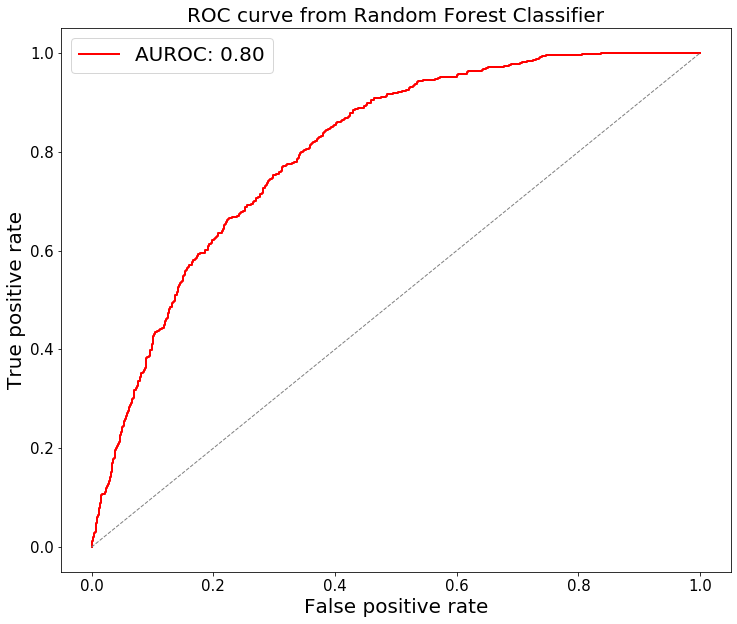

In [0]:
# RF - draw ROC and compute the AUC 
fpr, tpr, thresholds = roc_curve(y_test, pred_probs_RF)
roc_auc = auc(fpr, tpr)

# plotting ROCs
plt.gcf().set_size_inches(12, 10)
plt.plot(fpr, tpr, lw=2, color='red', label='AUROC: %0.2f'% roc_auc)
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.ylabel('True positive rate', fontsize=20)
plt.xlabel('False positive rate', fontsize=20)
plt.title('ROC curve from Random Forest Classifier', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.show()

Feature ranking:
1. feature: baseline_PF (0.686284)
2. feature: avg_t_spo2 (0.022305)
3. feature: age (0.016751)
4. feature: avg_t_respiratoryrate (0.015750)
5. feature: min_t_glucose (0.011059)
6. feature: avg_t_glucose (0.010987)
7. feature: max_t_spo2 (0.010932)
8. feature: max_t_wbc (0.009813)
9. feature: avg_t_temperature (0.009781)
10. feature: max_t_respiratoryrate (0.009292)
11. feature: avg_t_wbc (0.009273)
12. feature: avg_t_potassium (0.009199)
13. feature: min_t_spo2 (0.009125)
14. feature: max_t_BUN (0.008840)
15. feature: min_t_wbc (0.008738)
16. feature: avg_t_BUN (0.008655)
17. feature: max_t_temperature (0.008028)
18. feature: avg_t_calcium (0.007876)
19. feature: min_t_nibp_diastolic (0.007638)
20. feature: min_t_calcium (0.007550)
21. feature: min_t_hematocrit (0.007439)
22. feature: max_t_RBC (0.007403)
23. feature: min_t_creatinine (0.007378)
24. feature: max_t_gcs (0.007158)
25. feature: avg_t_hematocrit (0.007135)
26. feature: max_t_potassium (0.006984)
27. featu

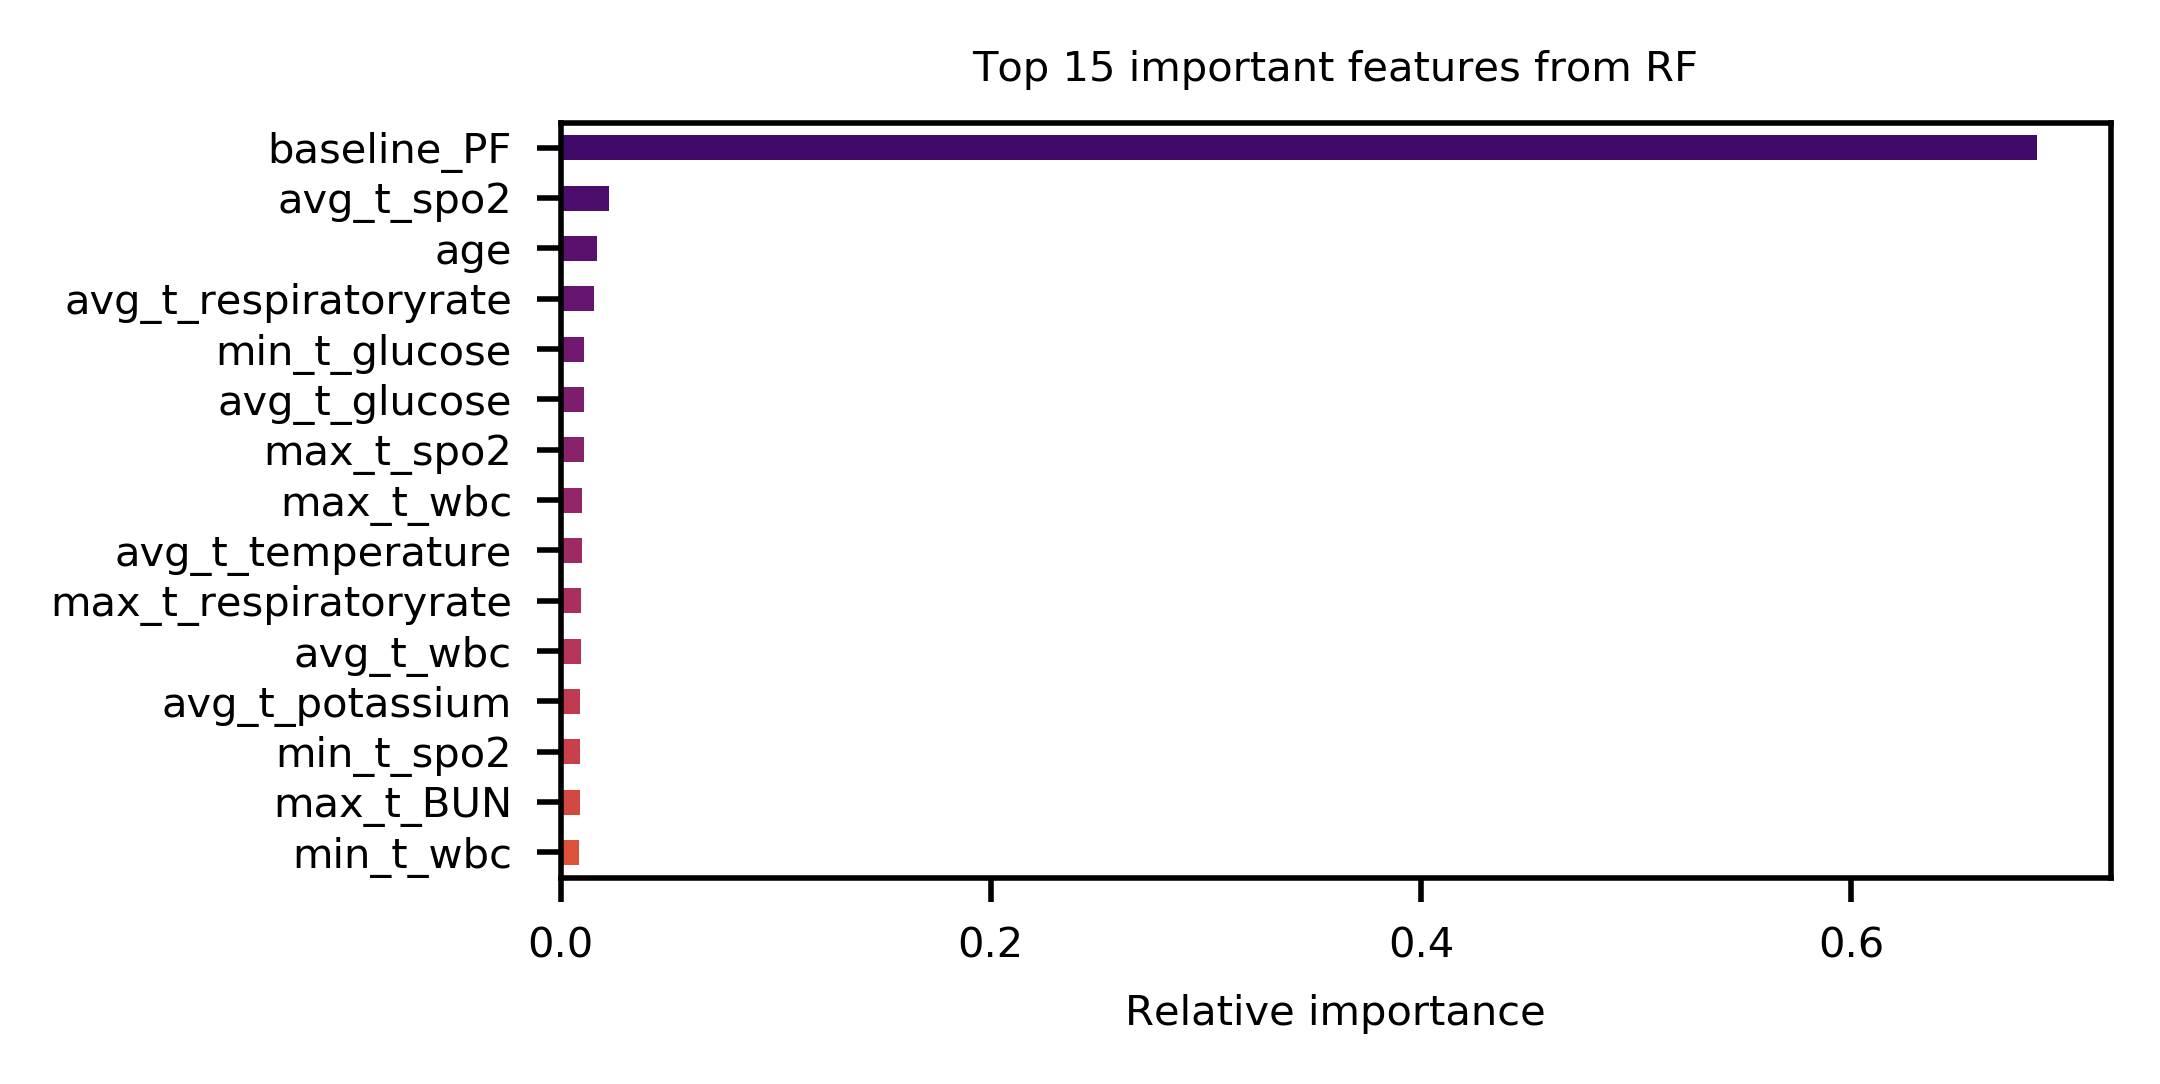

In [0]:
####### feature importances from RF ##############
forest = CV_rfc.best_estimator_.steps[1][1]
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(importances)):
    print("%d. feature: %s (%f)" % (f + 1, iXtrain.columns[indices[f]], importances[indices[f]]))

# importance plot:
#plt.gcf().set_size_inches(15, 6)
plt.figure(figsize=(4, 2), dpi=500)
feat_importances = pd.Series(importances[indices], index=iXtrain.columns[indices])
feat_importances.nlargest(15)[::-1].plot(kind='barh',fontsize=6,color=cm.inferno_r(np.linspace(.4,.8, 15)))
plt.title('Top 15 important features from RF', fontsize=6)
plt.xlabel('Relative importance', fontsize=6)
plt.show()

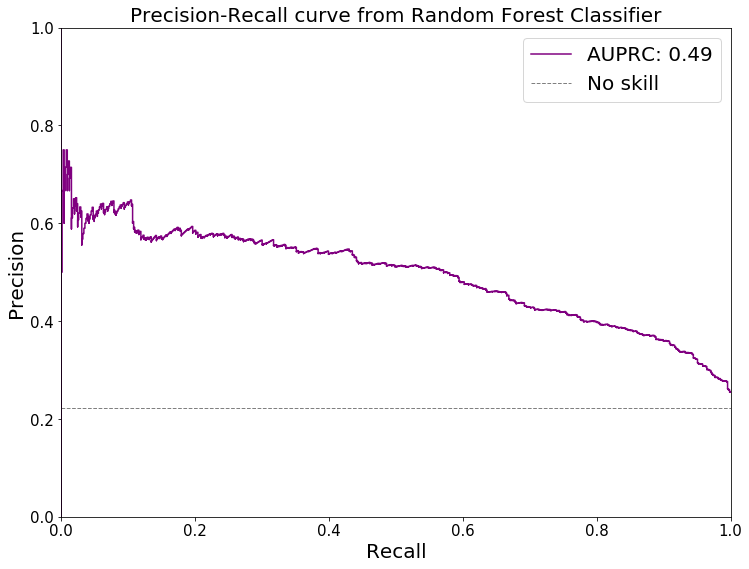

In [0]:
########## Plotting Precision-recall curve ############
precision, recall, _ = precision_recall_curve(np.array(y_test), pred_probs_RF)
#average_precision = average_precision_score(y_test, pred_probs_RF)
pr_auc = auc(recall, precision)
plt.gcf().set_size_inches(12, 9)
plt.step(recall, precision, color='purple', alpha=1, where='post', label='AUPRC: %0.2f'% pr_auc)
plt.axhline(y = sum(y_test.is_worse)/len(y_test.is_worse), linewidth=1, color='gray', linestyle='--', label='No skill')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.title('Precision-Recall curve from Random Forest Classifier',fontsize=20)
plt.legend(loc='upper right', fontsize=20)

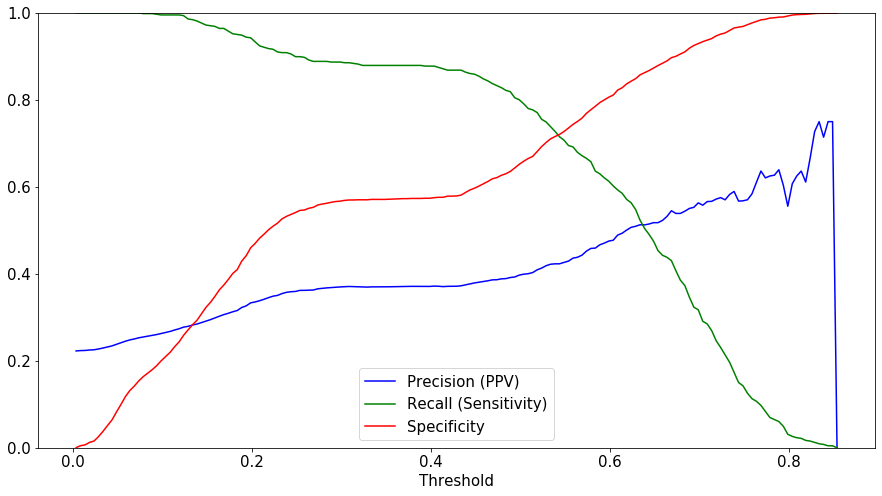

In [0]:
plot_metrics(y_test,pred_probs_RF)

In [0]:
# Export data
################# Write results to the disk ##################
df_pred_scores = pd.DataFrame(pred_probs_RF)
df_pred_scores.columns = ['RF']
df_y_test = pd.DataFrame(y_test)
df_y_test.columns = ['true_outcome']
df_y_test = df_y_test.reset_index(level=0)
df_results = pd.concat([df_y_test, df_pred_scores],axis=1)
#df_results.to_csv("Testset_prediction_results_RF.csv",index=False)

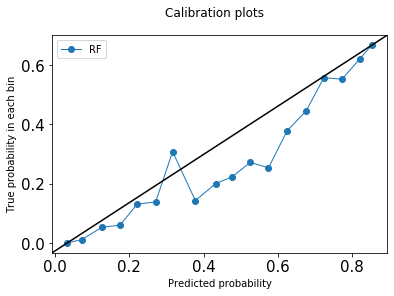

In [0]:
rf_y, rf_x = calibration_curve(y_test, pred_probs_RF, n_bins=20)

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(rf_x,rf_y, marker='o', linewidth=1, label='RF')
#plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='other')

# reference line, legends, and axis labels
line      = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plots')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

In [0]:
# Analysis (optional)
def bin_total(y, n_bins):
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)

    # In sklearn.calibration.calibration_curve,
    # the last value in the array is always 0.
    binids = np.digitize(y, bins) - 1
    

    return np.bincount(binids, minlength=len(bins))

In [0]:
bb = bin_total(y_test.is_worse, n_bins=20)
bb/bb.sum()

array([0.77731817, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.22268183,
       0.        ])

In [0]:
aa = bin_total(pred_probs_RF, n_bins=20)
aa/aa.sum()

array([0.06618407, 0.09341606, 0.09824199, 0.11513271, 0.07135471,
       0.02240607, 0.00448121, 0.00241296, 0.02240607, 0.05860048,
       0.07997242, 0.0789383 , 0.08479835, 0.07824888, 0.06928645,
       0.04308859, 0.00999655, 0.00103413, 0.        , 0.        ,
       0.        ])

In [0]:
rf_y

array([0.        , 0.01107011, 0.05263158, 0.05988024, 0.13043478,
       0.13846154, 0.30769231, 0.14285714, 0.2       , 0.22352941,
       0.27155172, 0.25327511, 0.37804878, 0.44493392, 0.55721393,
       0.552     , 0.62068966, 0.66666667])

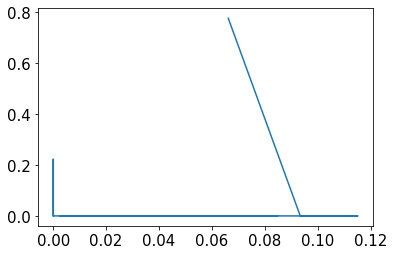

In [0]:
plt.plot(aa/aa.sum(), bb/bb.sum())

# Second run after further tunning parameters

In [0]:
## Random Forest Classifier model with CV
pred_probs_RF, iXtrain, iXtest, CV_rfc = fitRandomForestClassifier(X_train, X_test, y_train.is_worse, y_test.is_worse)

In [0]:
# RF - draw ROC and compute the AUC 
fpr, tpr, thresholds = roc_curve(y_test, pred_probs_RF)
roc_auc = auc(fpr, tpr)

# plotting ROCs
plt.gcf().set_size_inches(12, 10)
plt.plot(fpr, tpr, lw=2, color='red', label='AUROC: %0.2f'% roc_auc)
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--', label='No skill')
plt.ylabel('True positive rate', fontsize=20)
plt.xlabel('False positive rate', fontsize=20)
plt.title('ROC curve from Random Forest Classifier', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.show()

In [0]:
####### feature importances from RF ##############
forest = CV_rfc.best_estimator_.steps[1][1]
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(importances)):
    print("%d. feature: %s (%f)" % (f + 1, iXtrain.columns[indices[f]], importances[indices[f]]))

# importance plot:
plt.gcf().set_size_inches(15, 6)
feat_importances = pd.Series(importances[indices], index=iXtrain.columns[indices])
feat_importances.nlargest(10)[::-1].plot(kind='barh',fontsize=15,color=cm.inferno_r(np.linspace(.4,.8, 10)))
plt.title('Top 10 important features', fontsize=15)
plt.show()

In [0]:
########## Plotting Precision-recall curve ############
precision, recall, _ = precision_recall_curve(np.array(y_test), pred_probs_RF)
#average_precision = average_precision_score(y_test, pred_probs_RF)
pr_auc = auc(recall, precision)
plt.gcf().set_size_inches(12, 9)
plt.step(recall, precision, color='purple', alpha=1, where='post', label='AUPRC: %0.2f'% pr_auc)
plt.axhline(y = sum(y_test.is_worse)/len(y_test.is_worse), linewidth=1, color='gray', linestyle='--', label='No skill')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.title('Precision-Recall curve from Random Forest Classifier',fontsize=20)
plt.legend(loc='upper right', fontsize=20)